In [309]:
import random
import torch
from d2l import torch as d2l

### 生成数据集

In [310]:
# synthetic ==> 人造的、合成的
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [311]:
true_w = torch.tensor([2, -3.4]) # 权重向量
true_b = 4.2 # 偏置量
# 给出一个线性的真实权重（x 的系数）以及 真实的偏置量
# 最后是希望生成的数据的个数，由 w 可以知道特征的维度
features, labels = synthetic_data(true_w, true_b, 1000)

In [312]:
# 观察到 特征是二维的
print('features:', features[0])
print('label:', labels[0])

features: tensor([ 0.9830, -0.2285])
label: tensor([6.9489])


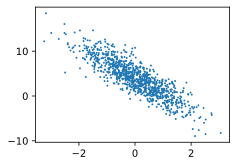

In [313]:
# 绘图 ==> 说明数据是线性关系
d2l.set_figsize()
# 表明只要第 1 号维度的特征并转化成 numpy 的 array，以及 labels==>y
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

### 读取数据

In [314]:
# 生成大小为 batch_size 的数据 ==> 从 features 和 labels 的数据进行打乱
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [315]:
# 读取小批量数据并打印
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X)
    print(y)
    break

tensor([[-1.6671,  0.6105],
        [ 0.9176, -1.8371],
        [ 1.9121,  0.1853],
        [-1.4983, -0.8516],
        [-0.9754, -1.0661],
        [ 0.4267,  2.7361],
        [-0.1598,  1.9698],
        [-0.5059, -0.5915],
        [ 0.4195,  0.8690],
        [-0.9490,  0.5349]])
tensor([[-1.1966],
        [12.2742],
        [ 7.4107],
        [ 4.0806],
        [ 5.8633],
        [-4.2180],
        [-2.8125],
        [ 5.2045],
        [ 2.0951],
        [ 0.4814]])


### 随机初始化线性模型的参数

In [316]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
w, b

(tensor([[-0.0060],
         [ 0.0011]], requires_grad=True),
 tensor([0.], requires_grad=True))

### 定义模型

In [317]:
# 广播机制
# 当使用一个向量 加上 一个标量的时候
# 标量 b 会依次加到向量的每个分量上去
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

### 定义损失函数

In [318]:
# 这个损失函数没有求和
# 得到的损失值是对多个样本的损失值的一个向量
# 这个向量中的每个元素记录的是对某一个样本的损失值
# 调用 squared_loss 函数后 ==> 对这个向量求和 ==> 聚合运算就可以了
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 定义 SGD 优化函数

In [319]:
# 加上 torch.no_grad() 后
# ==> 所执行的计算不会被记录在反向传播中
# 就是暂时性地忽略 requires_grad 属性为 True 的事实
# 这里的 SGD 只是用来更新权重的
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        # 更新 w 的过程不应该被记录和追踪
        for param in params:
            param -= lr * param.grad / batch_size
            # 在这里清除梯度值
            print("param : ", param.grad)
            param.grad.zero_()

### 定义网络 net

In [320]:
w1 = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b1 = torch.zeros(1, requires_grad=True)

w2 = torch.normal(0, 0.01, size=(1,1), requires_grad=True)
b2 = torch.zeros(1, requires_grad=True)

w1, b1, w2, b2

(tensor([[ 0.0060],
         [-0.0015]], requires_grad=True),
 tensor([0.], requires_grad=True),
 tensor([[0.0074]], requires_grad=True),
 tensor([0.], requires_grad=True))

In [321]:
def my_net(X, w1, b1, w2, b2):
    lin_reg1 = linreg(X, w1, b1)
    return linreg(lin_reg1, w2, b2)

In [322]:
my_net(X, w1, b1, w2, b2).shape, linreg(X, w, b).shape, X.shape

(torch.Size([10, 1]), torch.Size([10, 1]), torch.Size([10, 2]))

### 训练

In [323]:
lr = 0.03 # 学习率
num_epochs = 3 # 训练次数
net = my_net # 训练的网络的名称
loss = squared_loss # 损失函数

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        # net(X, w, b) ==> 这其实就是正向传播的过程
        # net(X, w, b) 等价于 y_hat
        # 再计算 y 和 y_hat 之间的损失即可
        l = loss(net(X, w1, b1, w2, b2), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward() # 通过这里计算出梯度
        
        # 因为 w2, b2 是手动定义出来的变量
        # 并不是通过手动定义的变量进行计算后得出的一个中间变量
        # 所以 w2 和 b2 也是求梯度的叶子节点
        # 它是不是叶子节点关键不在于这个变量在第几层网络
        # 而是在于这个变量是通过其他变量计算后得到的
        # 还是一开始就存在的 ==> 只要不是通过其他变量计算后得到
        # 那么这个变量就可以被计算梯度
        sgd([w1, b1, w2, b2], lr, batch_size)  # 使用参数的梯度更新参数
        
    # 每完成一轮数据集的训练之后
    # 就输出一些信息，来查看当前的损失状态
    with torch.no_grad():
        train_l = loss(net(features, w1, b1, w2, b2), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

param :  tensor([[-0.2510],
        [ 0.1961]])
param :  tensor([-0.2651])
param :  tensor([[-0.2401]])
param :  tensor([-35.6369])
param :  tensor([[-0.1708],
        [ 0.5426]])
param :  tensor([-0.5197])
param :  tensor([[-0.3275]])
param :  tensor([-63.6931])
param :  tensor([[-0.2415],
        [ 0.1554]])
param :  tensor([-0.3099])
param :  tensor([[-0.3336]])
param :  tensor([-33.8984])
param :  tensor([[-0.2630],
        [ 0.2295]])
param :  tensor([-0.4044])
param :  tensor([[-0.4312]])
param :  tensor([-39.8651])
param :  tensor([[-0.3986],
        [ 0.3016]])
param :  tensor([-0.4519])
param :  tensor([[-0.6103]])
param :  tensor([-39.5146])
param :  tensor([[-0.4064],
        [ 0.4626]])
param :  tensor([-0.6698])
param :  tensor([[-0.8003]])
param :  tensor([-50.4836])
param :  tensor([[0.0034],
        [0.0953]])
param :  tensor([-0.2474])
param :  tensor([[-0.1650]])
param :  tensor([-15.7893])
param :  tensor([[0.0125],
        [0.3722]])
param :  tensor([-0.2115])
param

In [324]:
# 因为这是自己合成的数据集
# 所以可以计算下，训练出来的 w 的值和 true_w 之间的差距
# 以及 true_b 和 b 的差距
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 2.0060, -3.4011], grad_fn=<SubBackward0>)
b的估计误差: tensor([4.2000], grad_fn=<RsubBackward1>)


### 我的小结

在之前的时候，我一直很困惑的是，当在线性回归的输入中一次性输入多个样本的时候，在最终的损失函数那里应该怎么处理？因为当输入多个样本的时候，转化成向量计算，可以计算出一个损失向量，这个损失向量包含了这一次输入的样本的个数那么多的损失值。想要表量化这个损失向量，非常简单，只需要使用 sum() 来聚合一下损失值，就可以把多个样本的损失值变成一个标量来看待了。

调用 backward 计算梯度，然后再使用 SGD 函数更新参数的值，在更新参数的值时，因为参数参与了运算，但是这个并不是正向传播的过程，不应该被记录下来

那么，在更新权重的值的时候，需要使用到样本数据吗？

不需要！因为在更新权重的时候，只需要使用 w <- w + (-lr*w.grad) 即可；这表明实在以 w 现在的位置为基础，然后移动一段距离，得到一个新的 w 然后赋值回去

w <- w + (-lr*w.grad) ==> w -= lr\*w.grad